In [2]:
import torch
from torchinfo import summary
import torch.optim as optim
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


from utils.metrics import validation_scores
from models.prediction.HVAE import ConditionalHierarchicalVAE
from utils.datasets import CIFAR_SR
from utils.utils import gaussian_kl


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
num_epochs = 100
batch_size = 512
scalefactor = 4

path = f"trained_models/HVAE_CIFAR_{scalefactor}x_prediction_mse3.pth"

latent_dims = [64, 128, 256]
condition_dims = [32, 64]
channels = [16, 32, 64, 128]
cond_channels = [16, 32]
in_channels = 3
cond_base_width = 32 // scalefactor
model = ConditionalHierarchicalVAE(in_channels=in_channels,
                          #latent_dims=latent_dims,
                          channels=channels,
                          cond_channels=cond_channels,
                          condition_dims=condition_dims,
                          cond_base_width=cond_base_width
                          ).to(device)
print(model.sample(torch.randn(1, in_channels, cond_base_width, cond_base_width).to(device)).shape)
summary(model, input_size=[(1, in_channels, 32, 32), (1, in_channels, cond_base_width, cond_base_width)])

torch.Size([1, 3, 32, 32])


Layer (type:depth-idx)                        Output Shape              Param #
ConditionalHierarchicalVAE                    [1, 3, 32, 32]            --
├─ConditionalHierarchicalEncoder: 1-1         [1, 64]                   --
│    └─Conv2d: 2-1                            [1, 16, 32, 32]           64
│    └─Conv2d: 2-2                            [1, 32, 16, 16]           8,224
│    └─Conv2d: 2-3                            [1, 64, 8, 8]             32,832
│    └─Conv2d: 2-4                            [1, 128, 4, 4]            131,200
│    └─Linear: 2-5                            [1, 64]                   131,136
│    └─Linear: 2-6                            [1, 64]                   131,136
│    └─Linear: 2-7                            [1, 128]                  524,416
│    └─Linear: 2-8                            [1, 128]                  524,416
│    └─Linear: 2-9                            [1, 256]                  2,097,408
│    └─Linear: 2-10                           [1, 256]  

In [4]:
train_dataset = CIFAR_SR(scale_factor=scalefactor, split='train')
test_dataset = CIFAR_SR(scale_factor=scalefactor, split='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_train_data = len(train_dataset)
print(f"Dataset Loaded: {len(train_dataset)} training samples, {len(test_dataset)} validation samples")

Dataset Loaded: 50000 training samples, 10000 validation samples


In [ ]:
# Adam opt
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = MSELoss()
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.9)

In [6]:
loss_list = []
recon_loss_list = []
kl_loss_list = []

In [7]:
def kl_annealing(step, total_steps, min_beta=0.0, max_beta=1.0):
    return min_beta + (max_beta - min_beta) * (step / total_steps)

In [ ]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.9)

In [60]:
optimizer.param_groups[0]["weight_decay"]

0.0001

In [61]:
num_epochs = 300

In [62]:
# kl_weight = 1
alpha = 50

for epoch in range(num_epochs):
    model.train()
    
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    # if epoch >= 20:
    #     kl_weight = 1
    #     alpha = 1000

    # kl_weight = kl_annealing(epoch, num_epochs, min_beta=0.0, max_beta=1.0)

    for HR, LR in train_loader:
        optimizer.zero_grad()

        recon_imgs, latents = model(HR, LR)

        recon_loss = criterion(recon_imgs, HR)
        kl_loss = 0
        for mu, logvar in latents:
            kl_loss += torch.mean(gaussian_kl(mu, logvar, torch.zeros_like(mu), torch.zeros_like(logvar)))
        loss = alpha *recon_loss + kl_weight * kl_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

    scheduler.step()    

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.6f} | Recon Loss: {total_recon_loss:.6f} | KL Loss: {total_kl_loss:.6f}")
    loss_list.append(total_loss)
    recon_loss_list.append(total_recon_loss)
    kl_loss_list.append(total_kl_loss)

Epoch [1/300] | Loss: 38.263760 | Recon Loss: 0.683288 | KL Loss: 4.140744
Epoch [2/300] | Loss: 38.251116 | Recon Loss: 0.683802 | KL Loss: 4.102040
Epoch [3/300] | Loss: 38.238695 | Recon Loss: 0.684242 | KL Loss: 4.067270
Epoch [4/300] | Loss: 38.232778 | Recon Loss: 0.684576 | KL Loss: 4.044417
Epoch [5/300] | Loss: 38.241468 | Recon Loss: 0.684984 | KL Loss: 4.032602
Epoch [6/300] | Loss: 38.240613 | Recon Loss: 0.685273 | KL Loss: 4.017155
Epoch [7/300] | Loss: 38.224625 | Recon Loss: 0.685198 | KL Loss: 4.004790
Epoch [8/300] | Loss: 38.211251 | Recon Loss: 0.685319 | KL Loss: 3.985151
Epoch [9/300] | Loss: 38.218879 | Recon Loss: 0.685589 | KL Loss: 3.979235
Epoch [10/300] | Loss: 38.205864 | Recon Loss: 0.685599 | KL Loss: 3.965553
Epoch [11/300] | Loss: 38.211673 | Recon Loss: 0.685874 | KL Loss: 3.957544
Epoch [12/300] | Loss: 38.207682 | Recon Loss: 0.685906 | KL Loss: 3.951902
Epoch [13/300] | Loss: 38.193960 | Recon Loss: 0.685881 | KL Loss: 3.939316
Epoch [14/300] | Loss

In [71]:
torch.save(model.state_dict(), path)

In [95]:
path = "testestest.pth"
# path = f"trained_models/HVAE_CIFAR_{scalefactor}x_prediction_mse3.pth"

In [96]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

[]

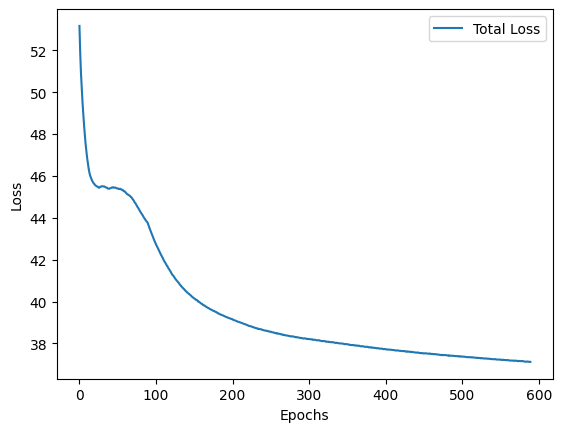

In [63]:
plt.plot(loss_list[10:], label='Total Loss')
# plt.plot(recon_loss_list[1:], label='Reconstruction Loss')
# plt.plot([l * kl_weight for l in kl_loss_list][1:], label='KL Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [97]:
HR, LR = test_dataset.get_samples(1000)
SR = model.sample(LR)
#SR = model(HR, LR)[0]

In [47]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

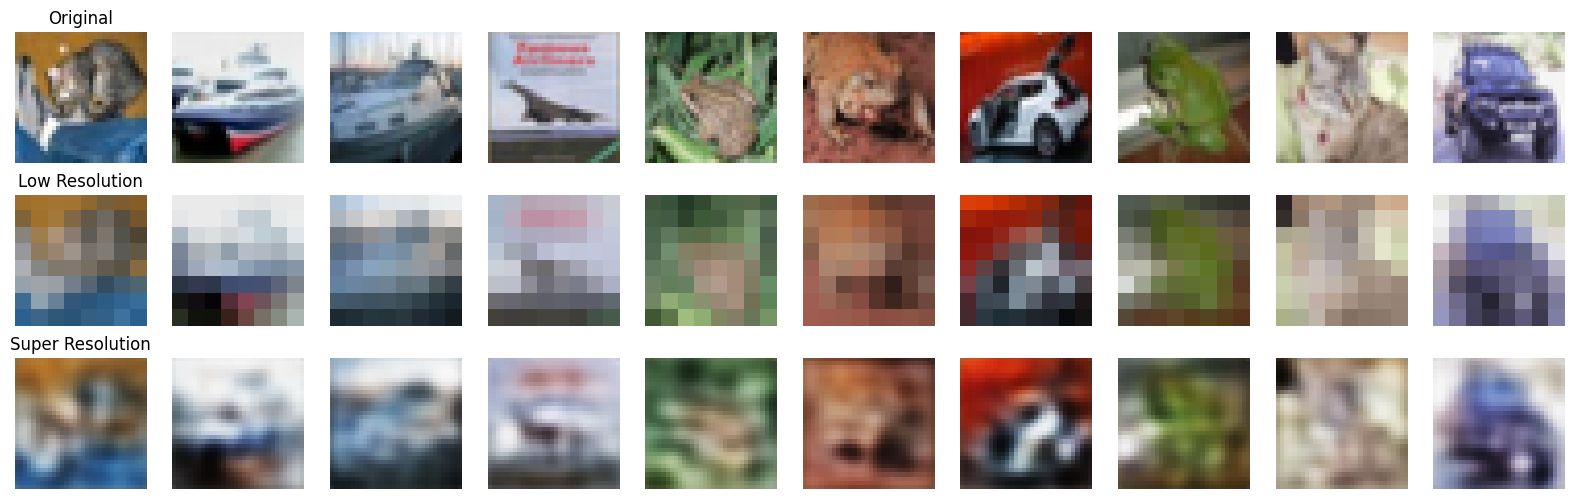

In [80]:
show_image(HR, LR, SR, 10)

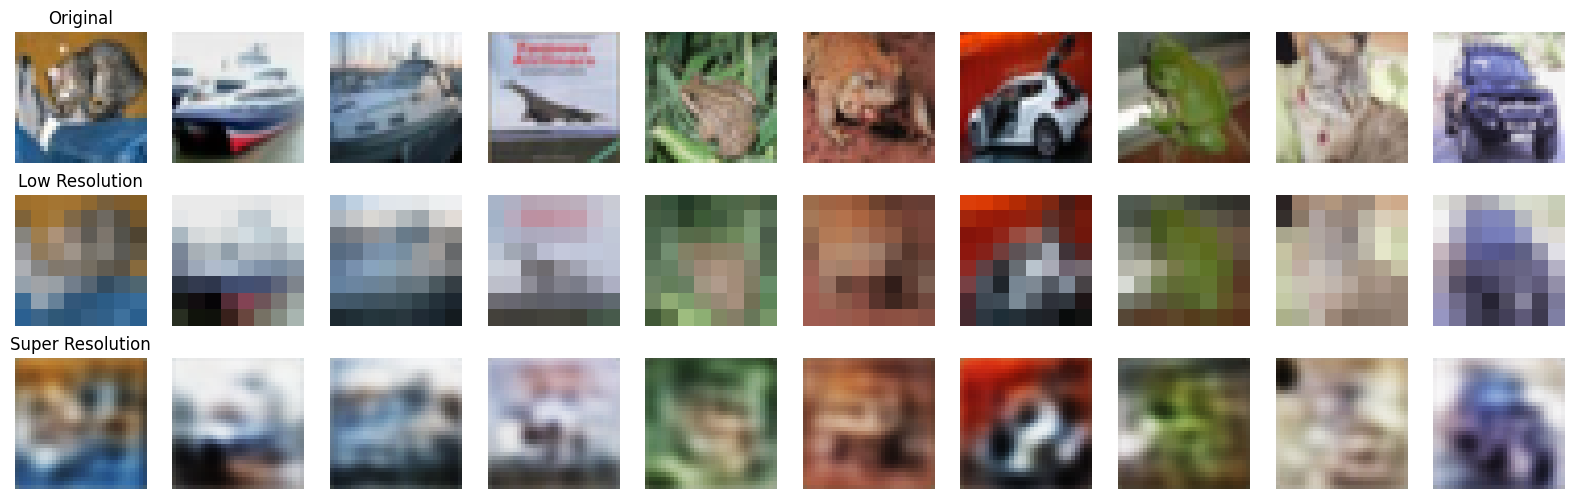

In [76]:
show_image(HR, LR, SR, 10)

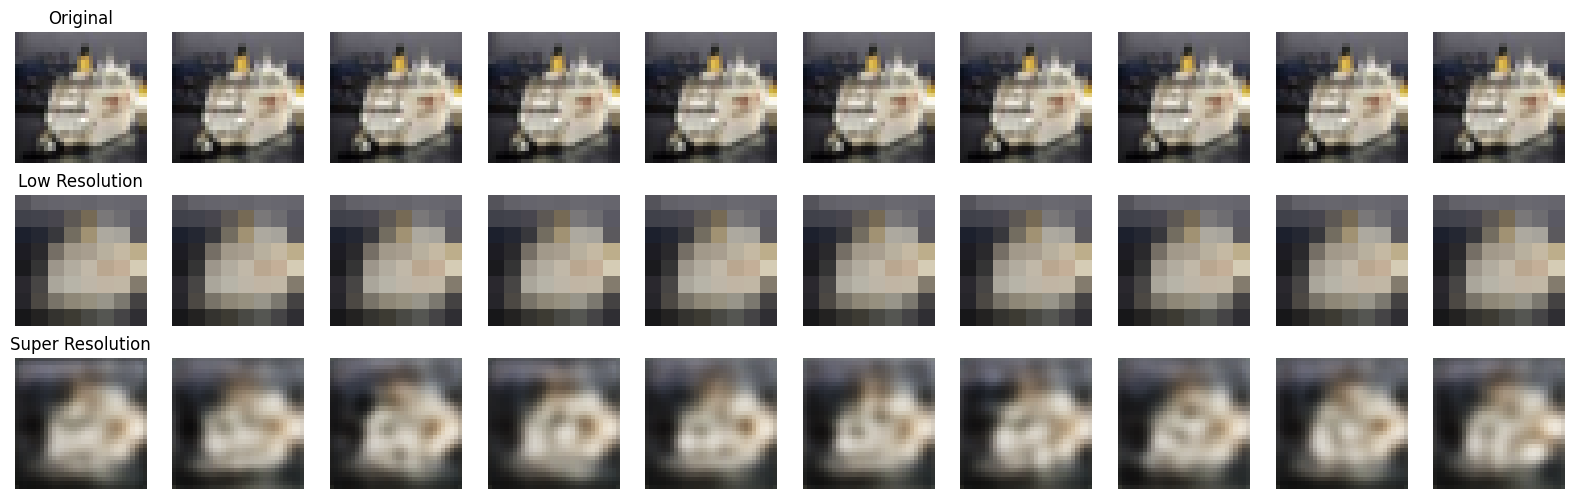

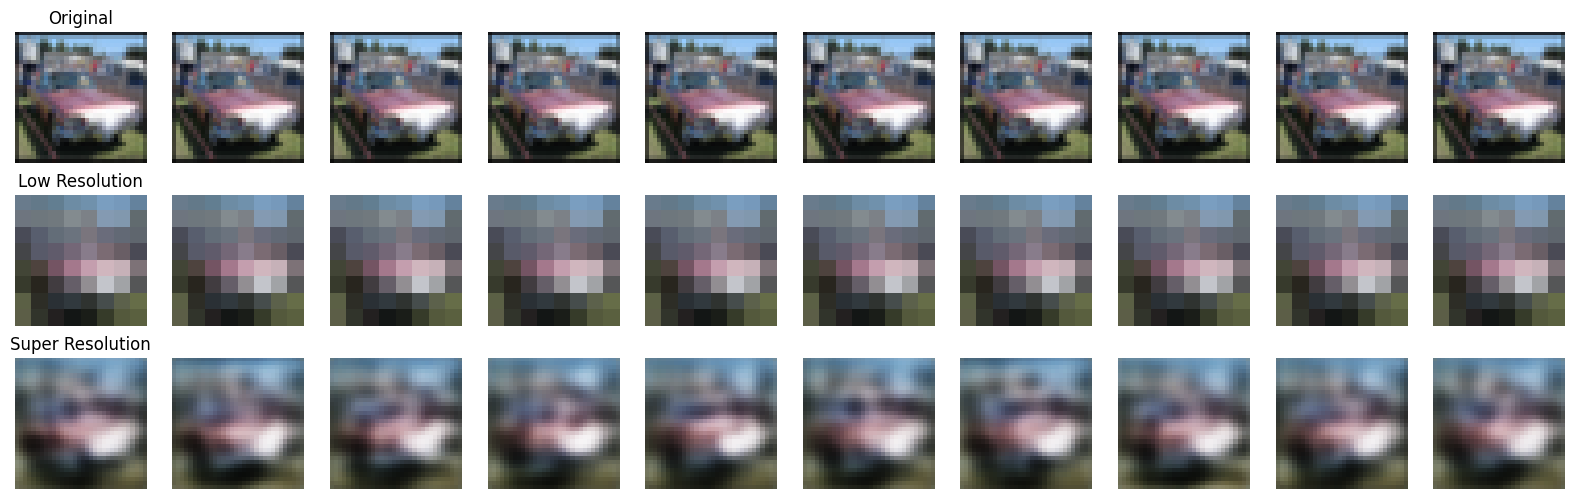

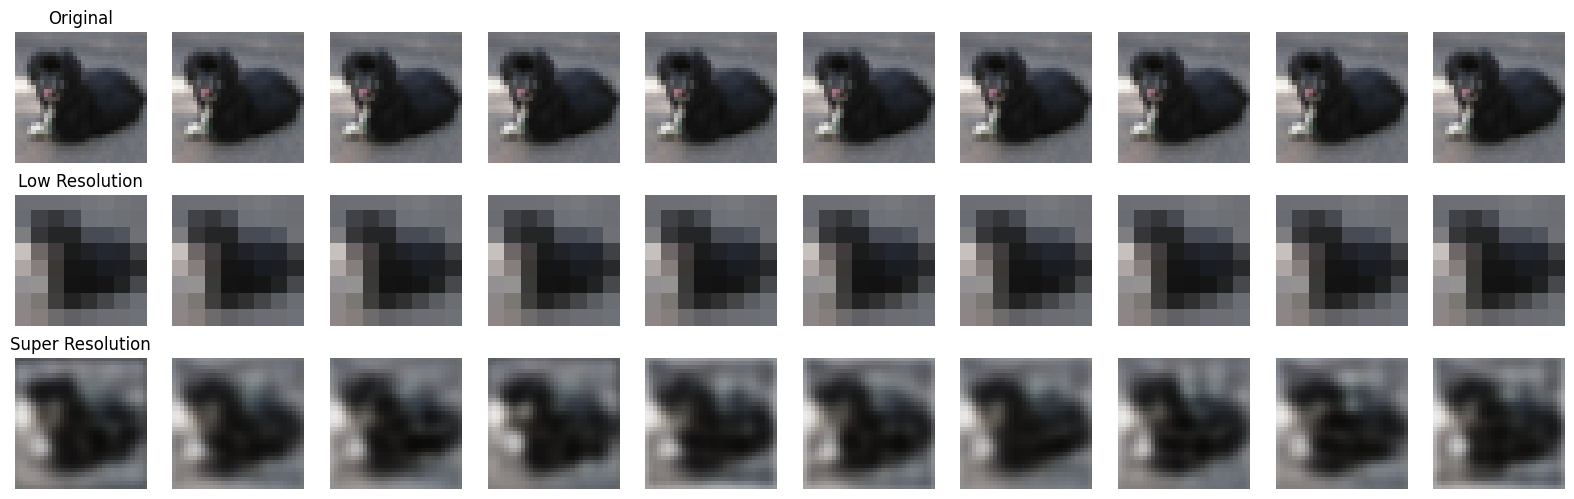

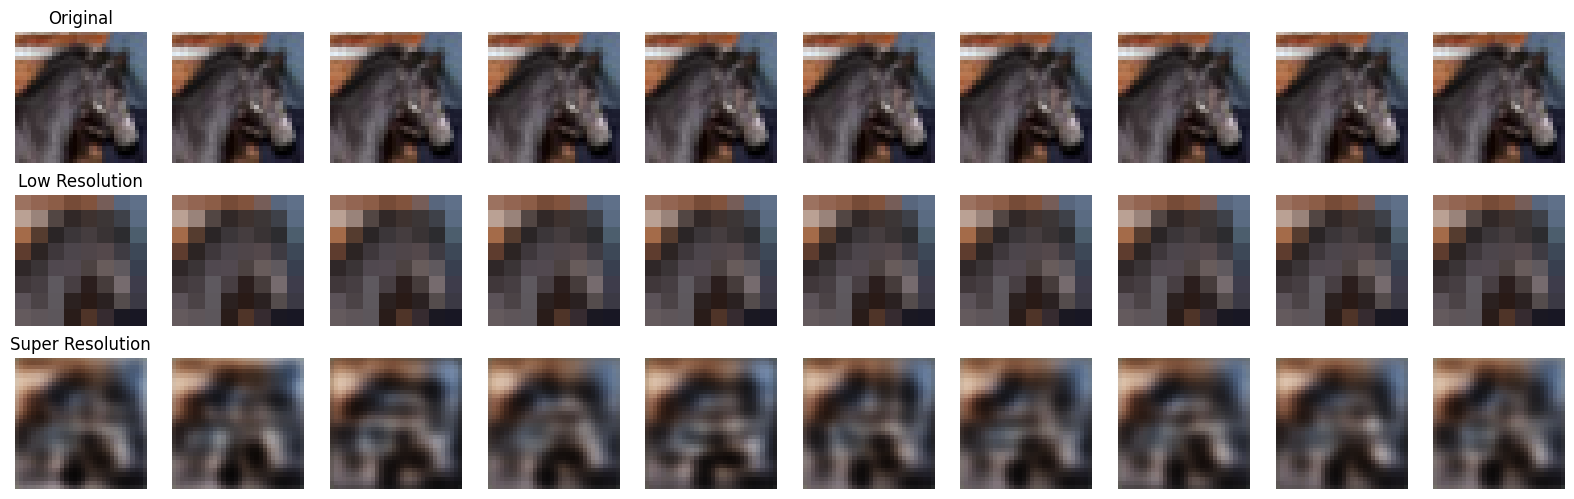

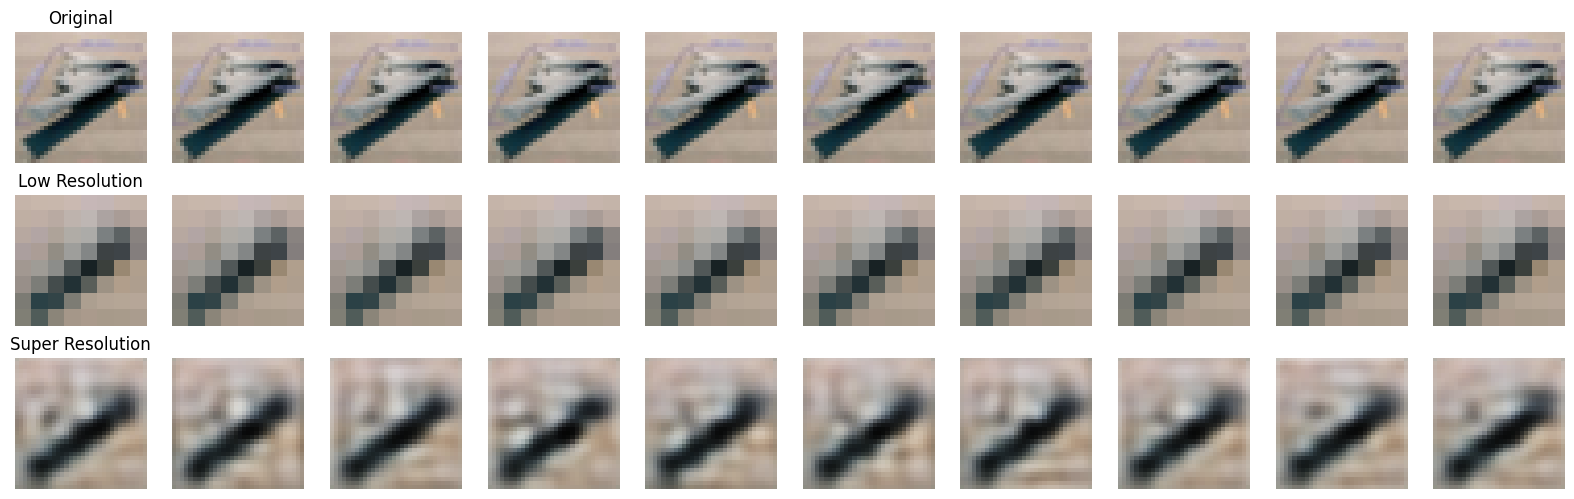

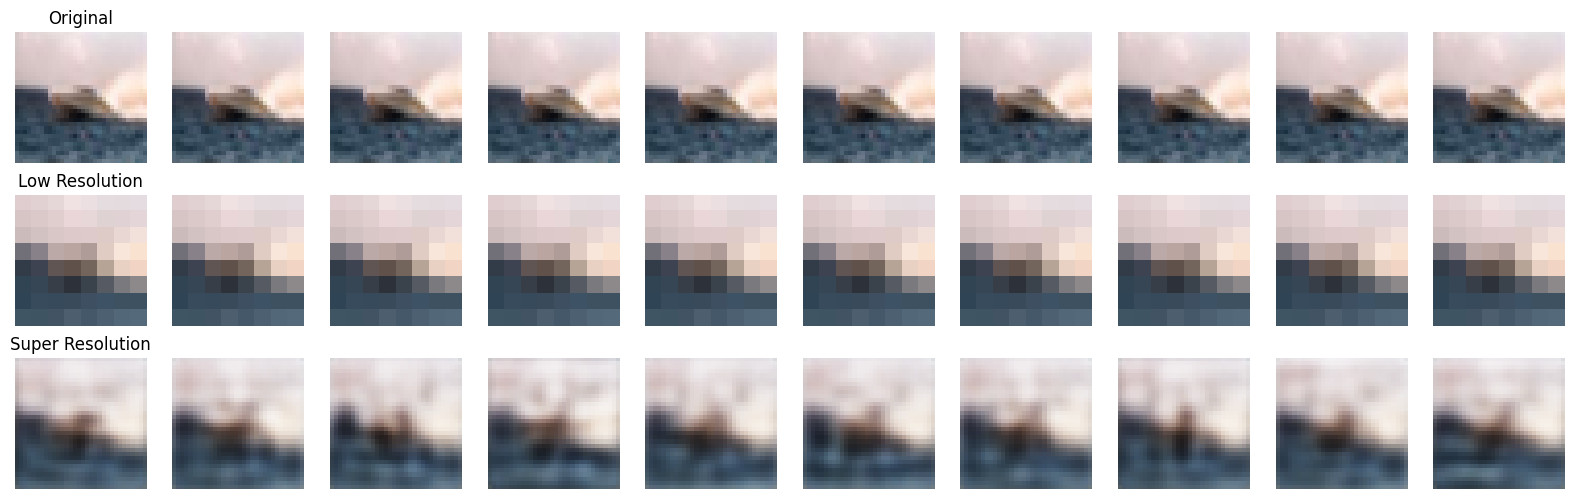

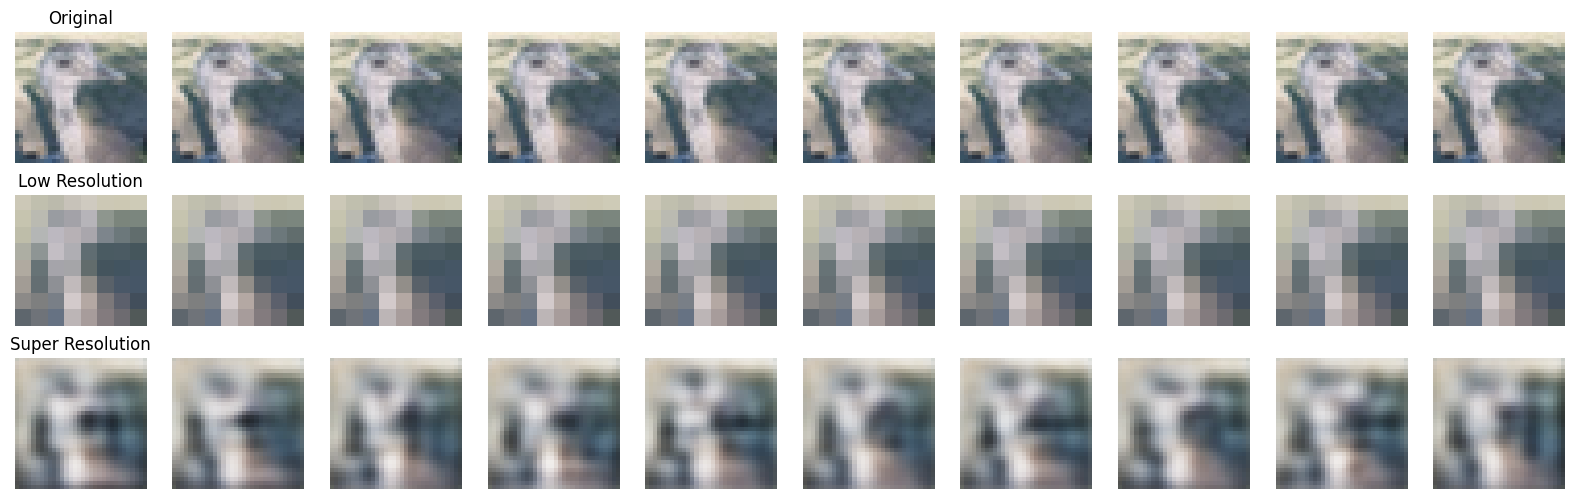

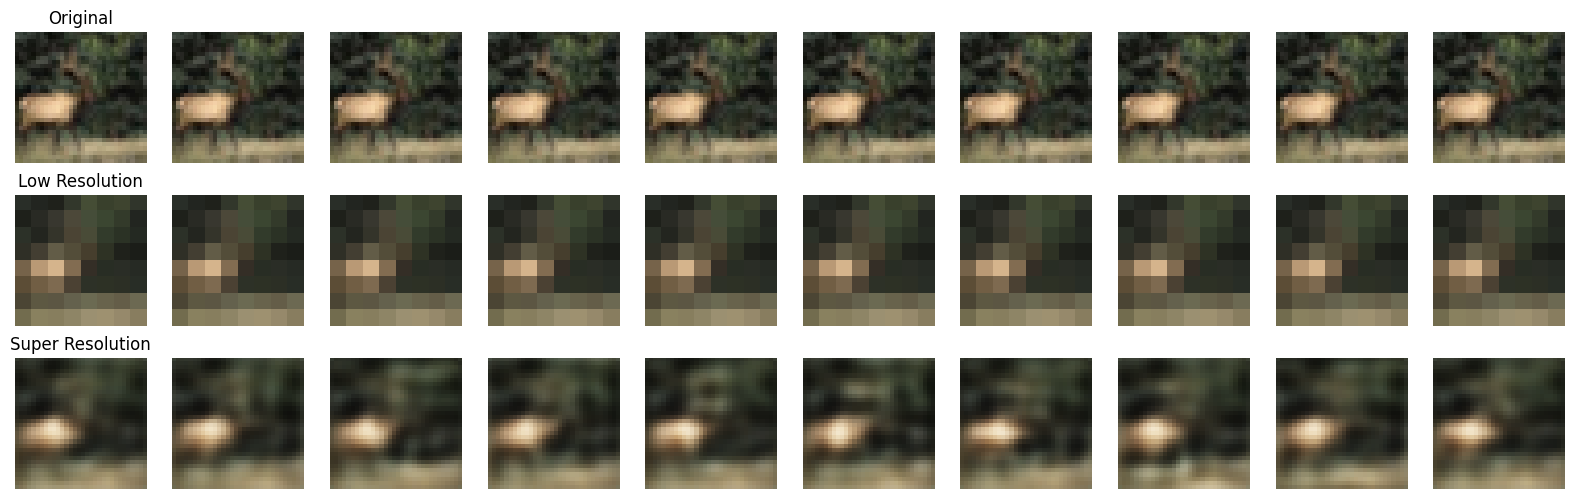

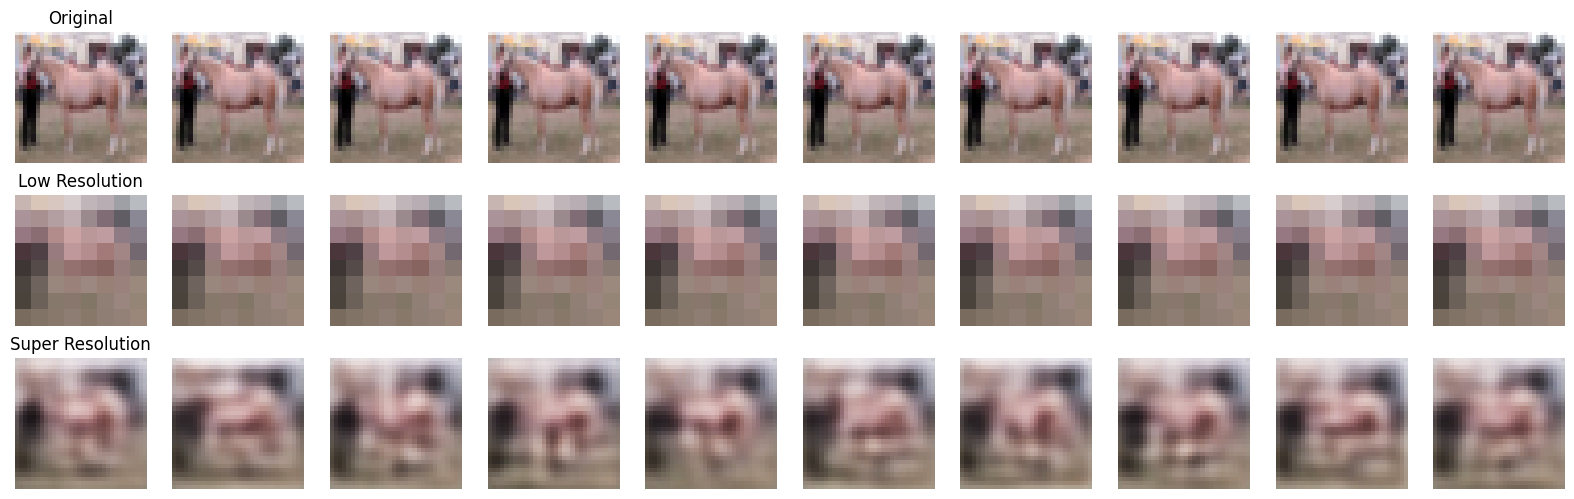

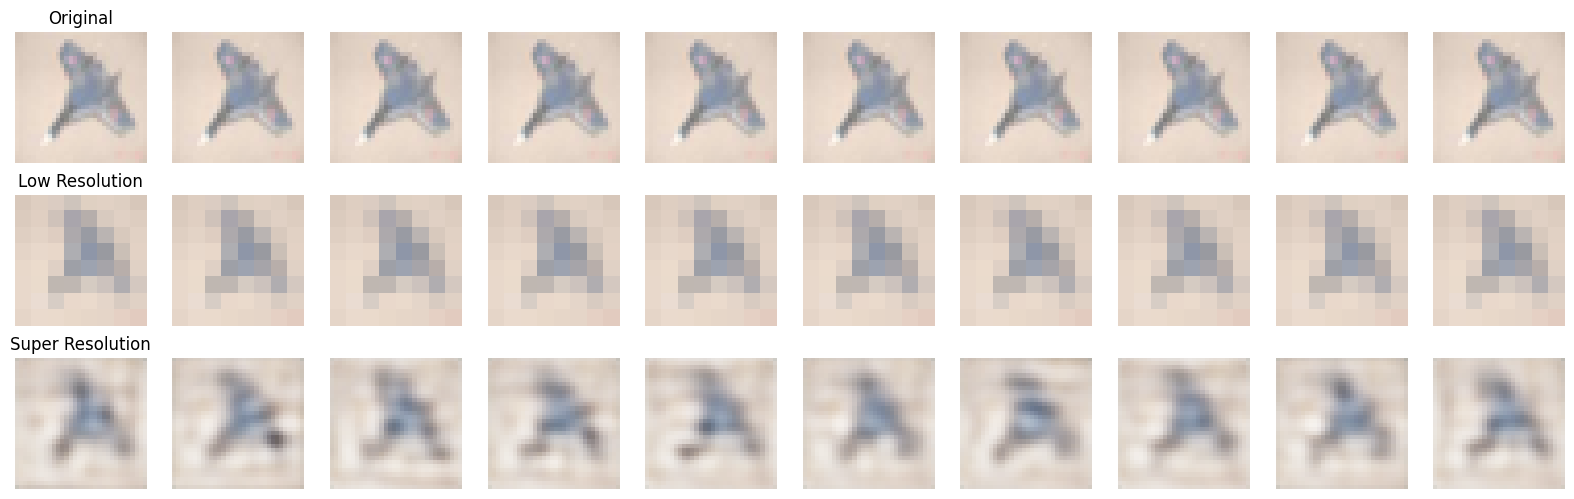

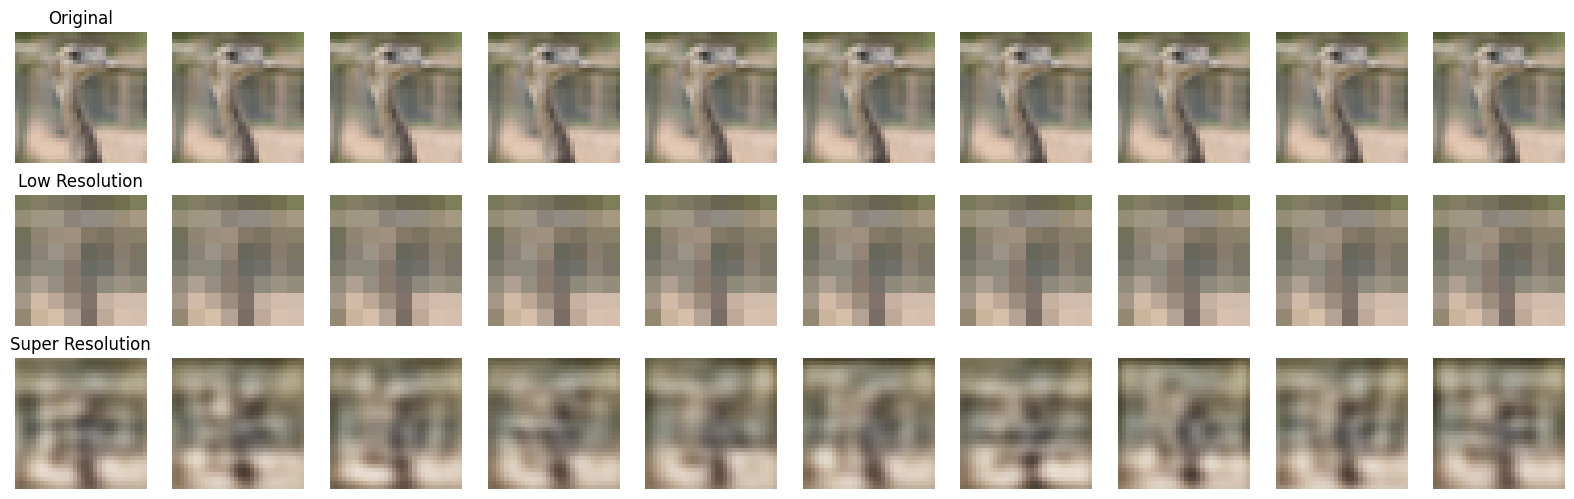

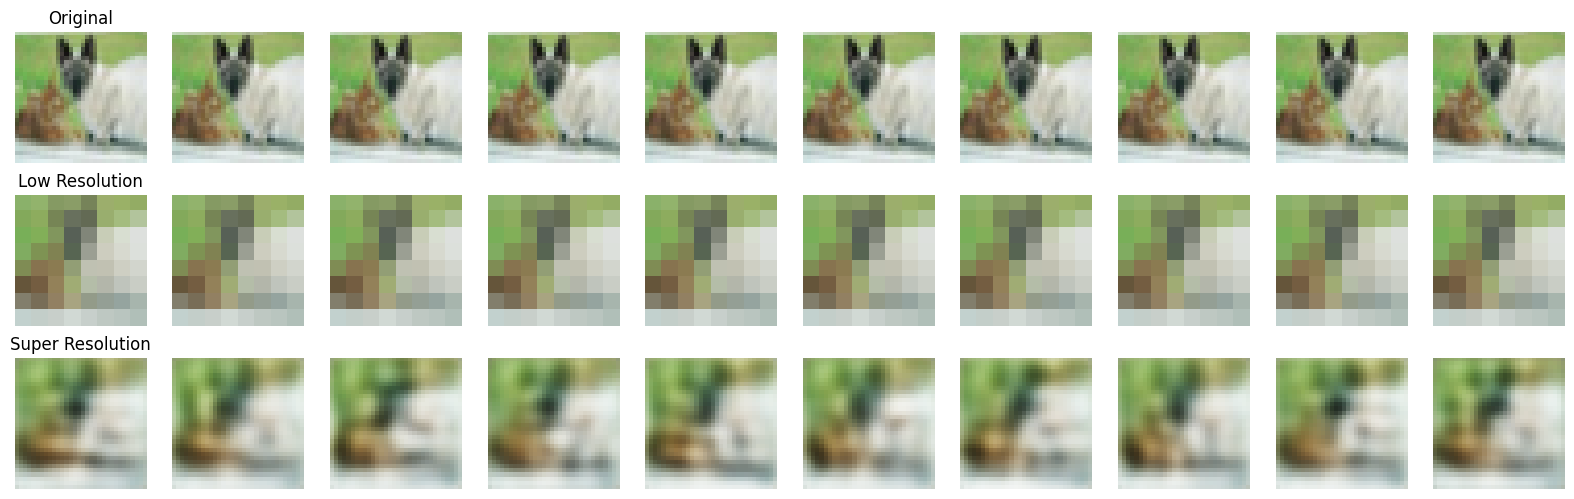

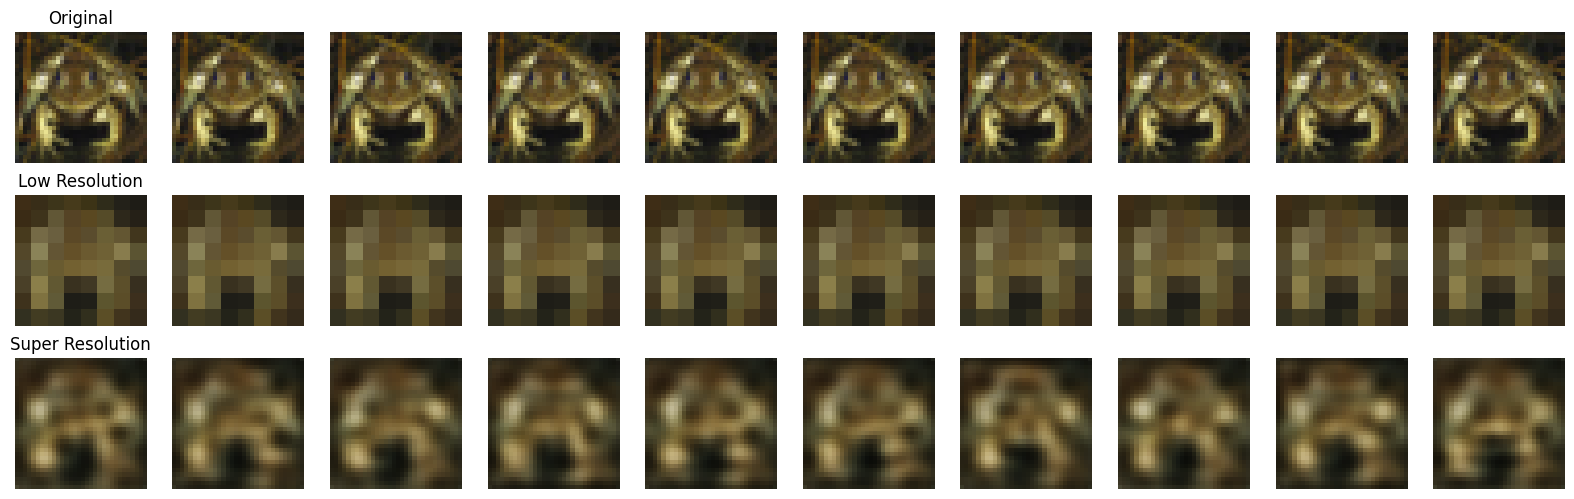

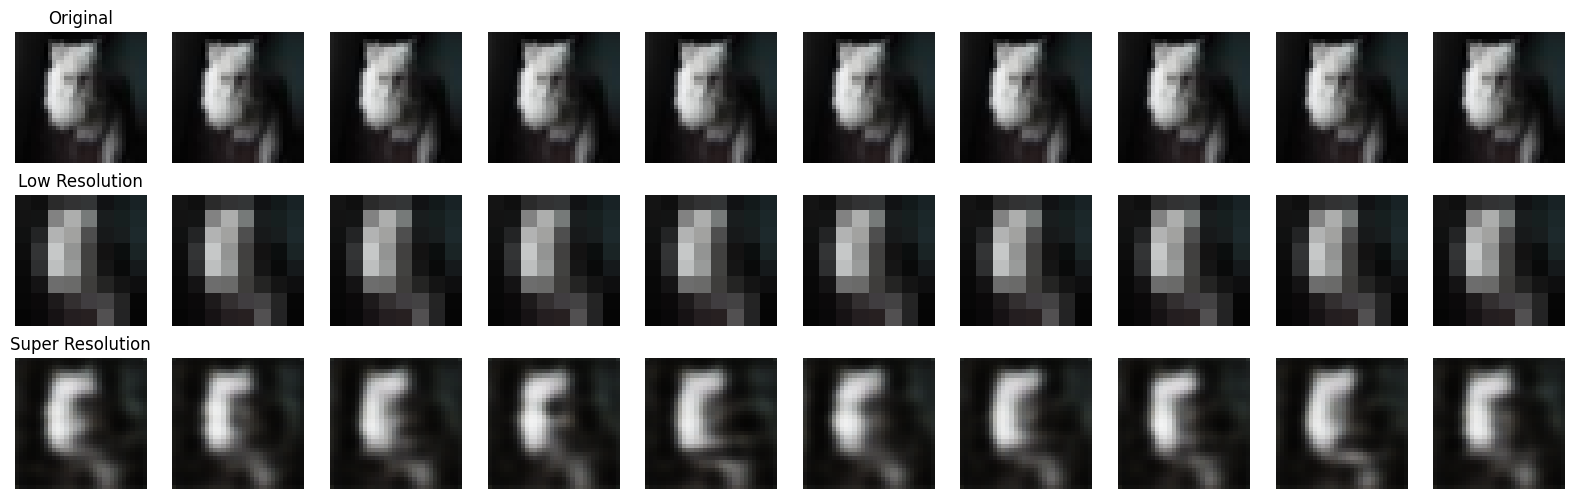

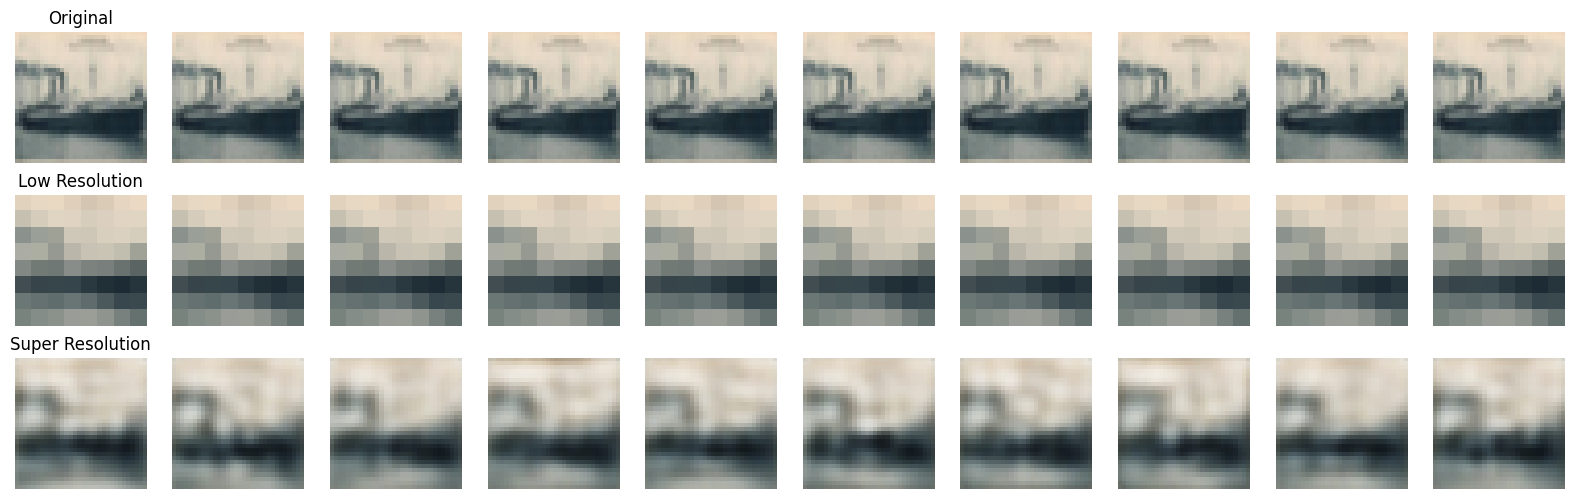

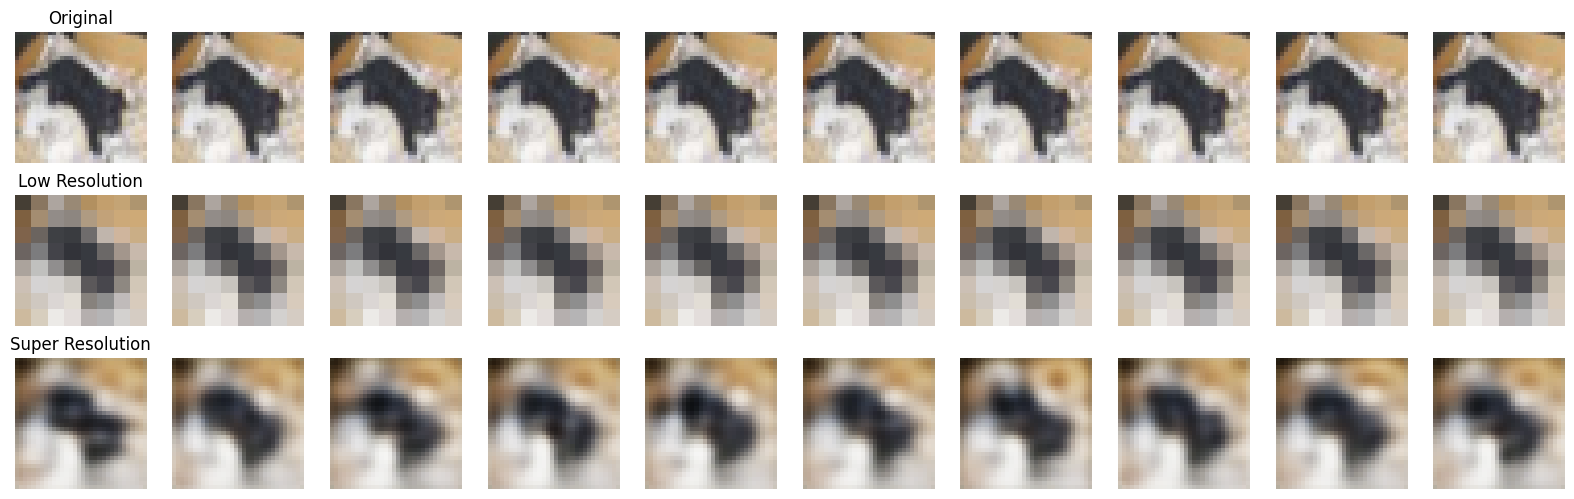

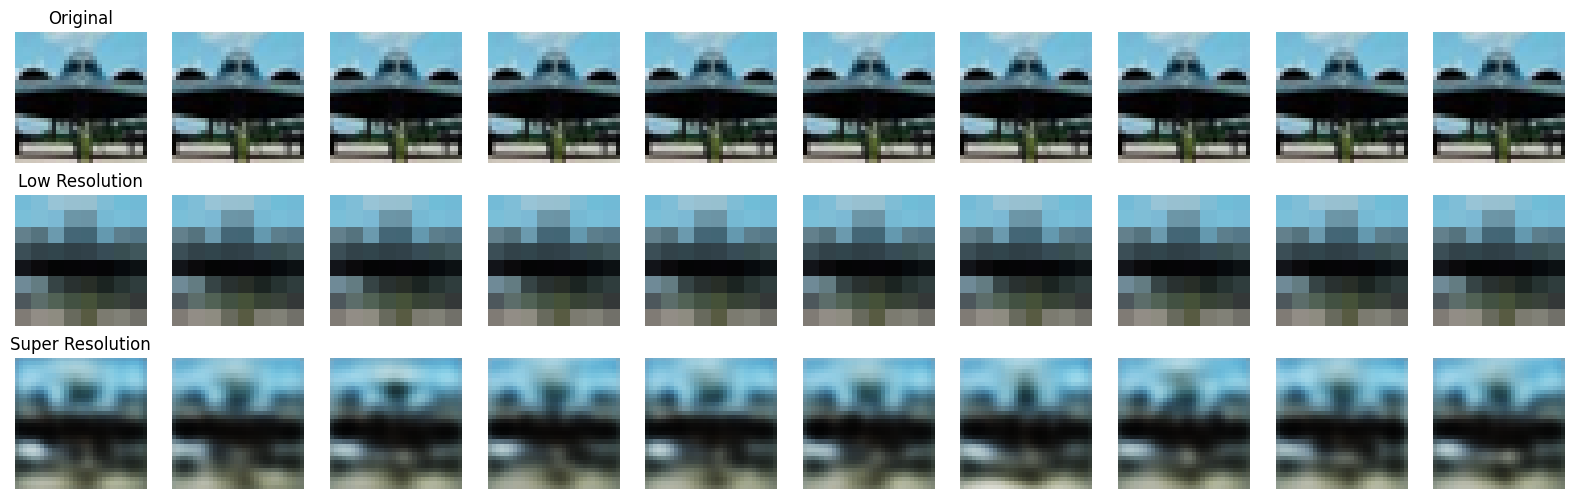

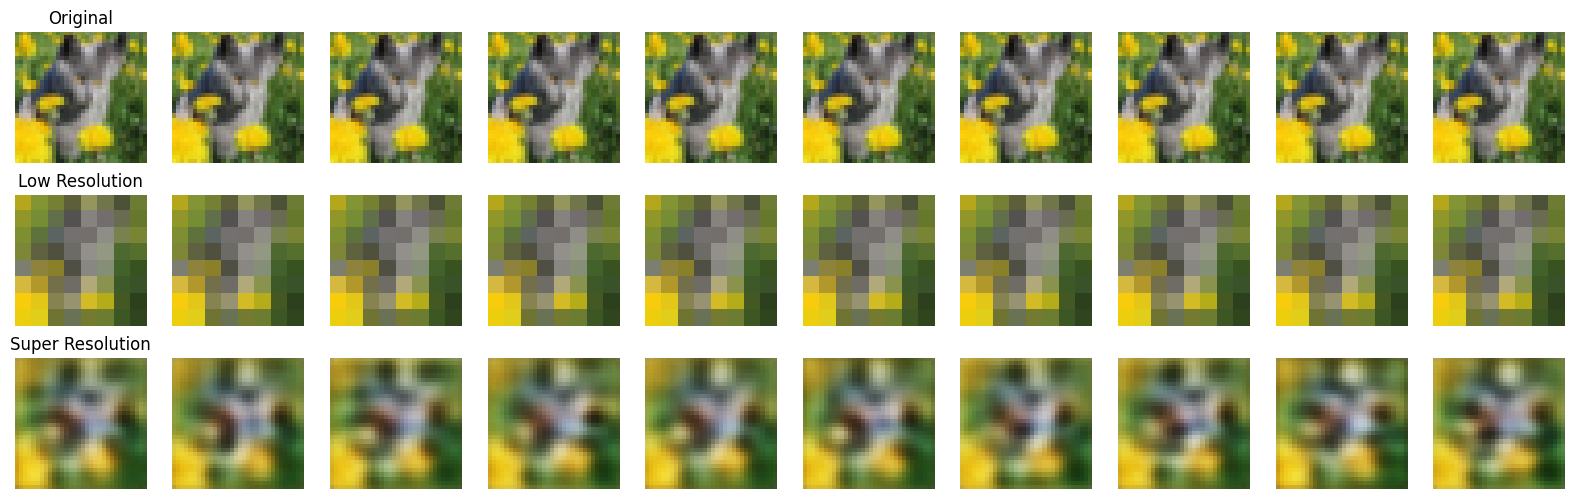

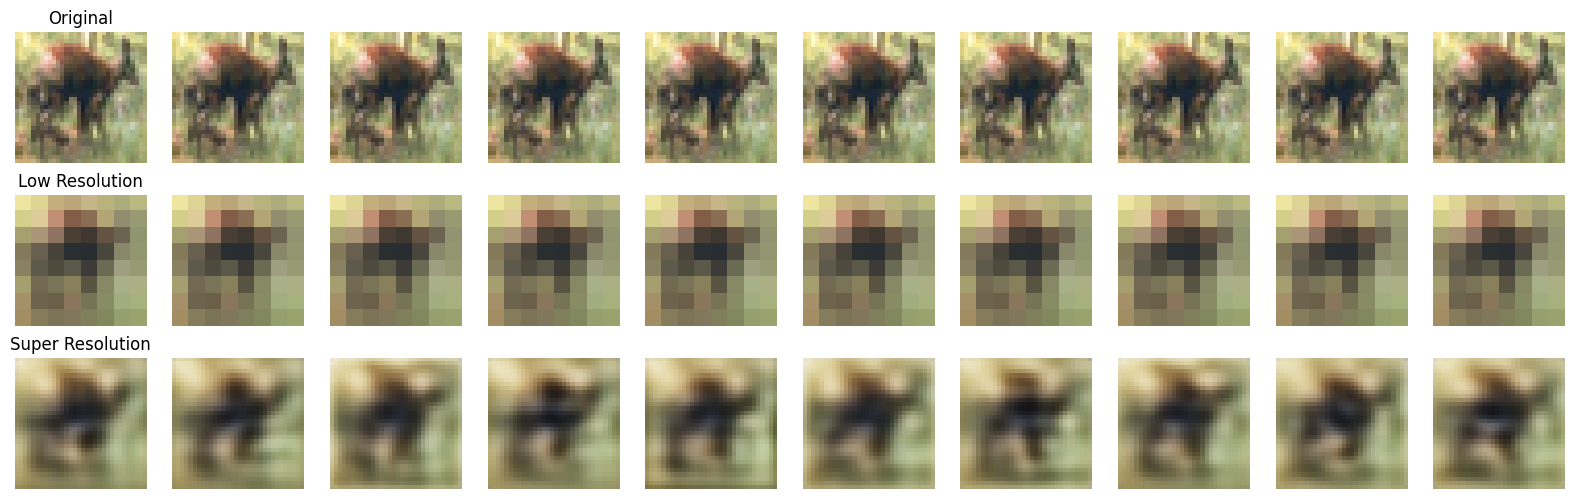

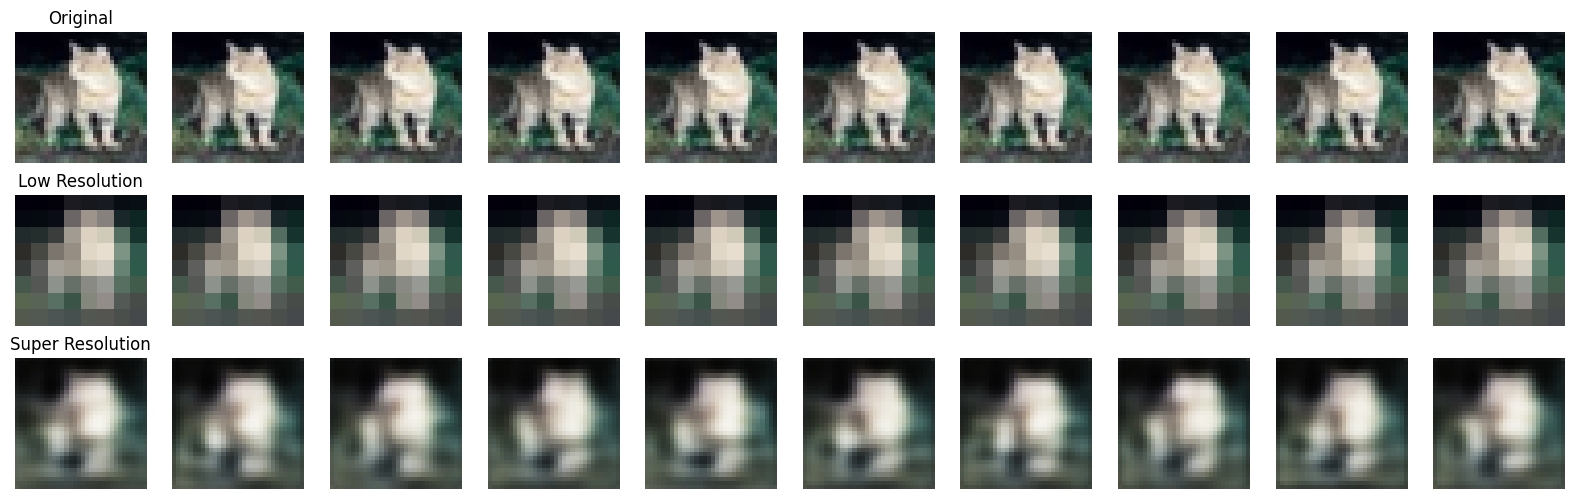

In [81]:
n_samp = 20
offset = 260

for i in range(offset, offset+n_samp):
    reference = HR[i]
    reference = reference.repeat(batch_size, 1, 1, 1)
    reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
    
    samples = model.sample(reference_inp).detach().cpu()

    show_image(reference, reference_inp, samples, 10)

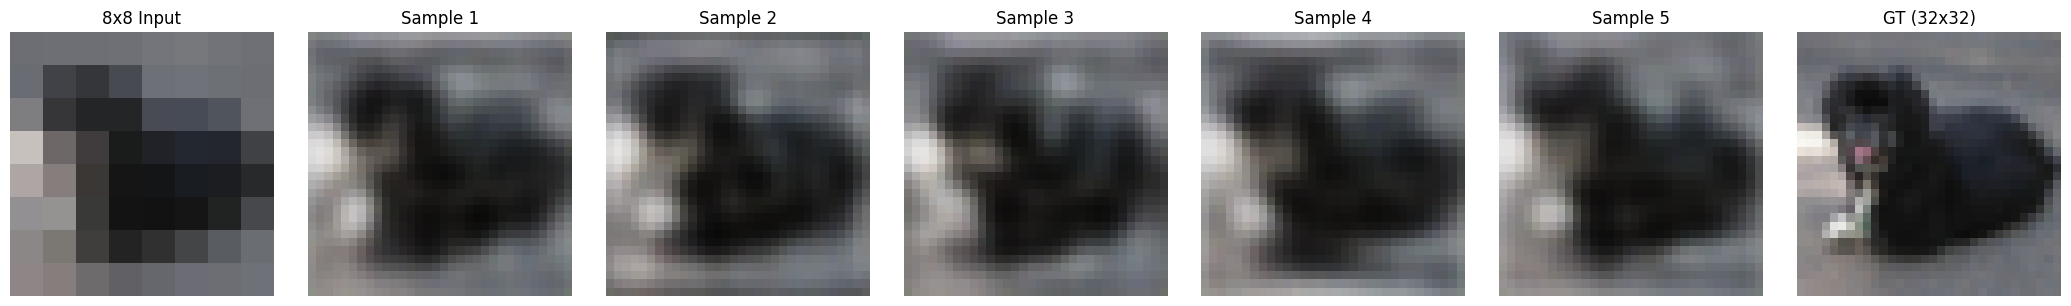

Diversity score (mean std across pixels): 0.03366
High diversity


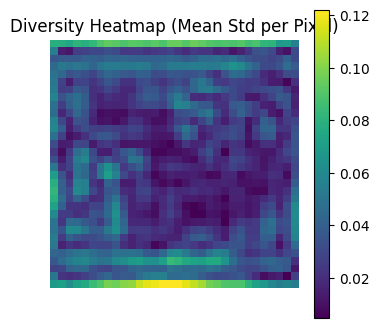

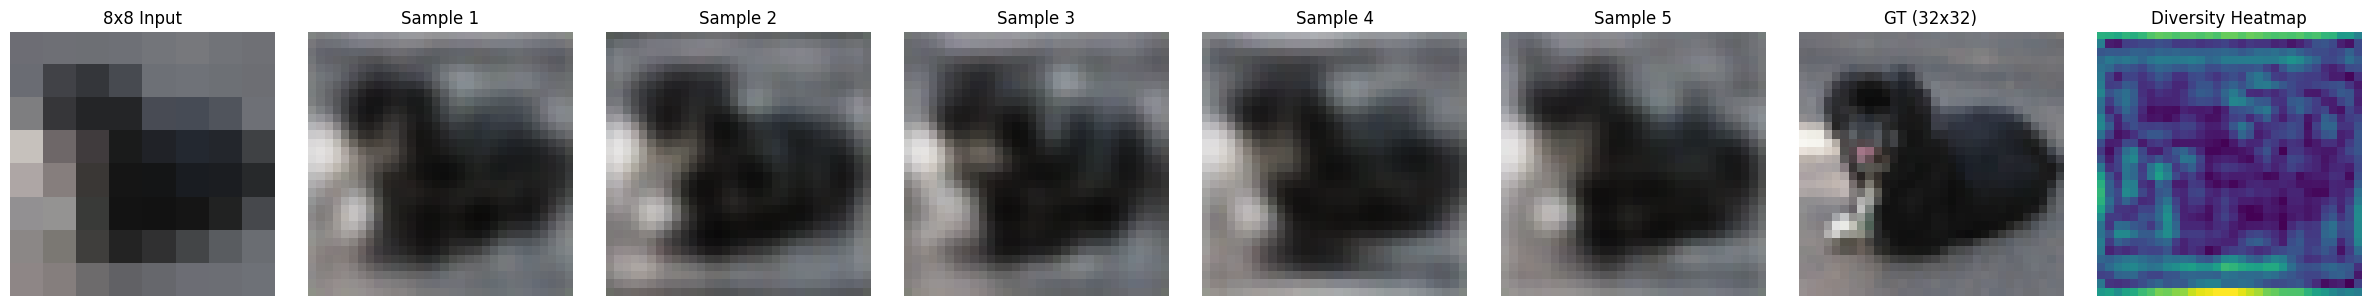

In [93]:
def visualize_diversity(model, lr_img, hr_img, num_samples=5):
    model.eval()
    generated_samples = []

    with torch.no_grad():
        # Prepare input
        lr_img = lr_img.unsqueeze(0)#.to(device)

        # Generate multiple predictions
        for _ in range(num_samples):
            recon_img = model.sample(lr_img)  # different latent each time
            generated_samples.append(recon_img.squeeze(0).cpu())  # (3, H, W)

    # Convert images for display
    lr_np = lr_img.cpu().squeeze().numpy().transpose(1, 2, 0)
    hr_np = hr_img.cpu().numpy().transpose(1, 2, 0)
    sample_nps = [sample.numpy().transpose(1, 2, 0) for sample in generated_samples]

    # ----- First Plot: Input + Samples + GT -----
    fig1, axs1 = plt.subplots(1, num_samples + 2, figsize=(3 * (num_samples + 2), 3))
    axs1[0].imshow(lr_np)
    axs1[0].set_title("8x8 Input")
    axs1[0].axis("off")

    for i, sample_np in enumerate(sample_nps):
        axs1[i + 1].imshow(sample_np)
        axs1[i + 1].set_title(f"Sample {i+1}")
        axs1[i + 1].axis("off")

    axs1[-1].imshow(hr_np)
    axs1[-1].set_title("GT (32x32)")
    axs1[-1].axis("off")

    plt.tight_layout()
    plt.show()

    # ----- Diversity Metric & Heatmap -----
    generated_stack = torch.stack(generated_samples)  # (num_samples, 3, H, W)
    std_per_pixel = torch.std(generated_stack, dim=0)  # (3, H, W)
    diversity_score = torch.mean(std_per_pixel).item()

    print(f"Diversity score (mean std across pixels): {diversity_score:.5f}")

    if diversity_score < 0.005:
        print("Very low diversity")
    elif diversity_score < 0.02:
        print("Moderate diversity")
    else:
        print("High diversity")

    diversity_map = torch.mean(std_per_pixel, dim=0).cpu().numpy()  # (H, W)

    # ----- Second Plot: Heatmap Only -----
    plt.figure(figsize=(4, 4))
    plt.imshow(diversity_map, cmap='viridis')
    plt.title("Diversity Heatmap (Mean Std per Pixel)")                                                           
    plt.colorbar()
    plt.axis("off")
    #plt.savefig(r"E:\GNN\gnn\datasets\models_neu\cifar32x32-4xscale\hvae-diversity-heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

    # ----- Third Plot: Combined Row with All -----
    fig3, axs3 = plt.subplots(1, num_samples + 3, figsize=(3 * (num_samples + 3), 3))

    axs3[0].imshow(lr_np)
    axs3[0].set_title("8x8 Input")
    axs3[0].axis("off")

    for i, sample_np in enumerate(sample_nps):
        axs3[i + 1].imshow(sample_np)
        axs3[i + 1].set_title(f"Sample {i+1}")
        axs3[i + 1].axis("off")

    axs3[-2].imshow(hr_np)
    axs3[-2].set_title("GT (32x32)")
    axs3[-2].axis("off")

    axs3[-1].imshow(diversity_map, cmap='viridis')
    axs3[-1].set_title("Diversity Heatmap")
    axs3[-1].axis("off")

    plt.tight_layout()
    #plt.savefig(r"E:\GNN\gnn\datasets\models_neu\cifar32x32-4xscale\hvae-diversity-combined.png", dpi=300, bbox_inches='tight')
    plt.show()


# Pick a random LR input
#hr_img, lr_img = val_dataset[random.randint(0, len(val_dataset)-1)]
visualize_diversity(model, LR[262], HR[262], num_samples=5)

In [ ]:
# old
mse_val, perceptual_val, psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("MSE:", mse_val)
print("Perceptual Loss:", perceptual_val)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MSE: 0.009670056402683258
Perceptual Loss: 5.485125541687012
PSNR: 20.56060791015625
SSIM: 0.5482911467552185
LPIPS: 0.417945921421051
BRISQUE: 73.31009674072266
PSNR Consistency: 35.348079681396484
MSE Diversity: 0.002521398948715614
LPIPS Diversity: 0.12350188548589358


In [98]:
#new
mse_val, perceptual_val, psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("MSE:", mse_val)
print("Perceptual Loss:", perceptual_val)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

MSE: 0.00930833164602518
Perceptual Loss: 5.369894027709961
PSNR: 20.752641677856445
SSIM: 0.5649670958518982
LPIPS: 0.4088311493396759
BRISQUE: 74.23359680175781
PSNR Consistency: 36.359500885009766
MSE Diversity: 0.0021735581424309203
LPIPS Diversity: 0.11359649384394288
